In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

print('Running on PyMC3 v{}'.format(pm.__version__))

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

# map_estimate = pm.find_MAP(model=basic_model)

# print map_estimate
    trace = pm.sample(500)



Running on PyMC3 v3.4.1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1000/1000 [00:01<00:00, 615.29it/s]


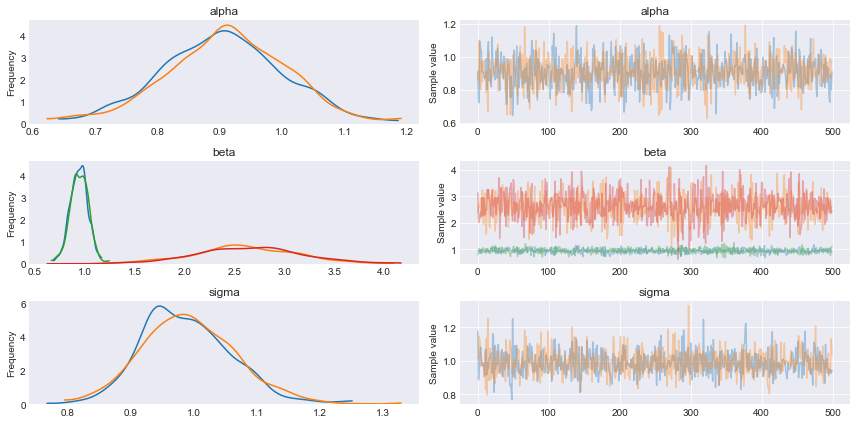

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.907,0.097,0.002,0.720,1.099,1362.728,1.000
beta__0,0.946,0.089,0.002,0.767,1.114,1549.999,1.000
beta__1,2.618,0.521,0.013,1.611,3.668,1412.045,1.001
sigma,0.990,0.073,0.002,0.840,1.124,1296.003,1.000


In [12]:
with basic_model:
    pm.traceplot(trace)
    plt.show()
pm.summary(trace).round(3)

In [18]:
from pandas_datareader import data
import pandas as pd
import datetime

start = datetime.datetime(2008, 5, 1)
end = datetime.datetime(2009, 12, 1)
returns = data.DataReader('F', 'morningstar', start, end)['Close'].pct_change()

len(returns)

414

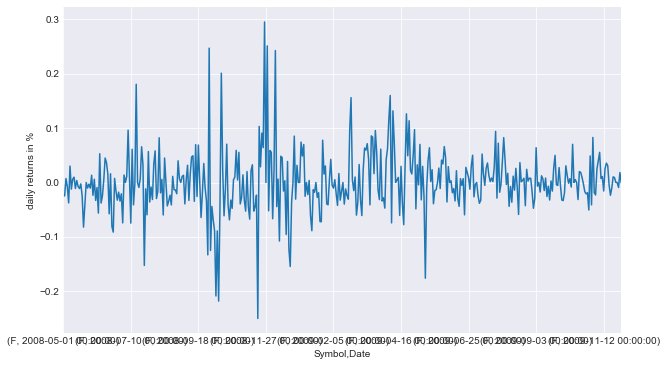

In [19]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');
plt.show()

In [20]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sd=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sd=volatility_process, observed=returns)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r_missing, s, sigma_log__, nu_log__]
100%|██████████| 2500/2500 [02:57<00:00, 14.12it/s]
The acceptance probability does not match the target. It is 0.9009347674216797, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


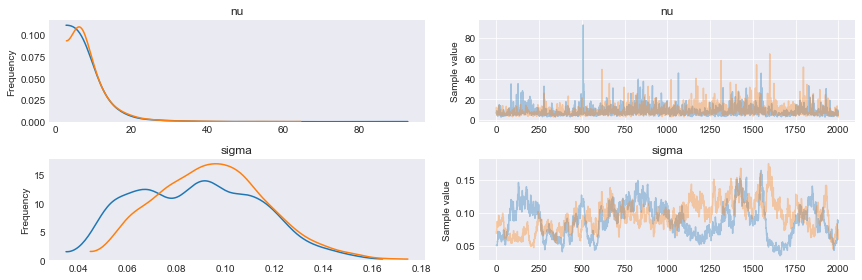

In [21]:
with sp500_model:
    trace = pm.sample(2000)
    
pm.traceplot(trace, varnames=['nu', 'sigma']);
plt.show()

In [44]:
np.shape(returns)

(414,)

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
for i in xrange(len(trace['s',::5])):
    ax.plot(returns.index, 1/np.exp(trace['s',::5][i,:]), 'C3', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

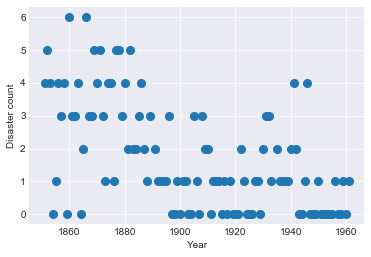

In [46]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

plt.show()

In [50]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

with disaster_model:
    trace = pm.sample(10000)

Only 20 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
  0%|          | 0/520 [00:00<?, ?it/s]


JoblibKeyError: JoblibKeyError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x104402a30, file "/ana...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x104402a30, file "/ana...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/anaconda/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/anaconda/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 19, 19, 58, 35, 441537, tzinfo=tzutc()), u'msg_id': u'D3DEFBE5BAF9431485F65FF5D16C9991', u'msg_type': u'execute_request', u'session': u'27250EB6D83A472B9736345EF609AAA3', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'D3DEFBE5BAF9431485F65FF5D16C9991', 'msg_type': u'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['27250EB6D83A472B9736345EF609AAA3']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 19, 19, 58, 35, 441537, tzinfo=tzutc()), u'msg_id': u'D3DEFBE5BAF9431485F65FF5D16C9991', u'msg_type': u'execute_request', u'session': u'27250EB6D83A472B9736345EF609AAA3', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'D3DEFBE5BAF9431485F65FF5D16C9991', 'msg_type': u'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['27250EB6D83A472B9736345EF609AAA3'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 6, 19, 19, 58, 35, 441537, tzinfo=tzutc()), u'msg_id': u'D3DEFBE5BAF9431485F65FF5D16C9991', u'msg_type': u'execute_request', u'session': u'27250EB6D83A472B9736345EF609AAA3', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'D3DEFBE5BAF9431485F65FF5D16C9991', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"with pm.Model() as disaster_model:\n\n    swit...nwith disaster_model:\n    trace = pm.sample(20)", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>, <_ast.With object>], cell_name='<ipython-input-50-3335392fa7e9>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 111c62390, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x112b9deb0, file "<ipython-input-50-3335392fa7e9>", line 14>
        result = <ExecutionResult object at 111c62390, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x112b9deb0, file "<ipython-input-50-3335392fa7e9>", line 14>, result=<ExecutionResult object at 111c62390, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x112b9deb0, file "<ipython-input-50-3335392fa7e9>", line 14>
        self.user_global_ns = {'In': ['', u"import numpy as np\nimport matplotlib.pyplot a...traceplot(trace)\n    pm.summary(trace).round(2)", u'with basic_model:\n    pm.traceplot(trace)', u'with basic_model:\n    pm.traceplot(trace)', u'with basic_model:\n    pm.traceplot(trace)', u"trace['alpha'][::5]", u'with basic_model:\n\npm.summary(trace).round(2)', u'with basic_model:\n    pm.traceplot(trace)\npm.summary(trace).round(2)', u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(2)', u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(3)', u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(3)', u"import numpy as np\nimport matplotlib.pyplot a...# print map_estimate\n    trace = pm.sample(500)", u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(3)', u"from pandas_datareader import data\nimport pan...009-12-1')['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...009-12-1')['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...009-12-1')['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...tart, end)['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...tart, end)['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...tart, end)['Close'].pct_change()\n\nlen(returns)", u"returns.plot(figsize=(10, 6))\nplt.ylabel('daily returns in %');\nplt.show()", ...], 'Out': {5: array([0.9180056 , 0.83524352, 0.9971895 , 0.758... 0.85882971, 0.99831036, 1.03874114, 0.91330989]), 7:          mean    sd  mc_error  hpd_2.5  hpd_97.5... 0.07      0.00     0.85      1.10  1662.65   1.0, 8:          mean    sd  mc_error  hpd_2.5  hpd_97.5... 0.07      0.00     0.85      1.10  1662.65   1.0, 9:           mean     sd  mc_error  hpd_2.5  hpd_97...068     0.002    0.850     1.100  1662.647  0.999, 10:           mean     sd  mc_error  hpd_2.5  hpd_97...068     0.002    0.850     1.100  1662.647  0.999, 12:           mean     sd  mc_error  hpd_2.5  hpd_97...073     0.002    0.840     1.124  1296.003  1.000, 18: 414, 22: array([[3.64539959, 3.62961346, 3.64547854, ...,....., 3.84696247, 3.86169031,
        3.87922259]]), 23: 800, 24: (800, 414), ...}, 'X1': array([-1.0856306 ,  0.99734545,  0.2829785 , -1...08456791, -1.36347154,  0.37940061, -0.37917643]), 'X2': array([ 0.12841094, -0.39557759,  0.14245293,  0...0538587 , -0.02217014, -0.06825234, -0.04358925]), 'Y': array([ 9.38706859e-01,  4.10296149e-01,  3.8398....20236525e-03,  1.36931418e+00,  1.33161104e+00]), 'Y_obs': Y_obs, '_': (414,), '_10':           mean     sd  mc_error  hpd_2.5  hpd_97...068     0.002    0.850     1.100  1662.647  0.999, '_12':           mean     sd  mc_error  hpd_2.5  hpd_97...073     0.002    0.840     1.124  1296.003  1.000, '_18': 414, ...}
        self.user_ns = {'In': ['', u"import numpy as np\nimport matplotlib.pyplot a...traceplot(trace)\n    pm.summary(trace).round(2)", u'with basic_model:\n    pm.traceplot(trace)', u'with basic_model:\n    pm.traceplot(trace)', u'with basic_model:\n    pm.traceplot(trace)', u"trace['alpha'][::5]", u'with basic_model:\n\npm.summary(trace).round(2)', u'with basic_model:\n    pm.traceplot(trace)\npm.summary(trace).round(2)', u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(2)', u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(3)', u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(3)', u"import numpy as np\nimport matplotlib.pyplot a...# print map_estimate\n    trace = pm.sample(500)", u'with basic_model:\n    pm.traceplot(trace)\n    plt.show()\npm.summary(trace).round(3)', u"from pandas_datareader import data\nimport pan...009-12-1')['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...009-12-1')['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...009-12-1')['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...tart, end)['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...tart, end)['Close'].pct_change()\n\nlen(returns)", u"from pandas_datareader import data\nimport pan...tart, end)['Close'].pct_change()\n\nlen(returns)", u"returns.plot(figsize=(10, 6))\nplt.ylabel('daily returns in %');\nplt.show()", ...], 'Out': {5: array([0.9180056 , 0.83524352, 0.9971895 , 0.758... 0.85882971, 0.99831036, 1.03874114, 0.91330989]), 7:          mean    sd  mc_error  hpd_2.5  hpd_97.5... 0.07      0.00     0.85      1.10  1662.65   1.0, 8:          mean    sd  mc_error  hpd_2.5  hpd_97.5... 0.07      0.00     0.85      1.10  1662.65   1.0, 9:           mean     sd  mc_error  hpd_2.5  hpd_97...068     0.002    0.850     1.100  1662.647  0.999, 10:           mean     sd  mc_error  hpd_2.5  hpd_97...068     0.002    0.850     1.100  1662.647  0.999, 12:           mean     sd  mc_error  hpd_2.5  hpd_97...073     0.002    0.840     1.124  1296.003  1.000, 18: 414, 22: array([[3.64539959, 3.62961346, 3.64547854, ...,....., 3.84696247, 3.86169031,
        3.87922259]]), 23: 800, 24: (800, 414), ...}, 'X1': array([-1.0856306 ,  0.99734545,  0.2829785 , -1...08456791, -1.36347154,  0.37940061, -0.37917643]), 'X2': array([ 0.12841094, -0.39557759,  0.14245293,  0...0538587 , -0.02217014, -0.06825234, -0.04358925]), 'Y': array([ 9.38706859e-01,  4.10296149e-01,  3.8398....20236525e-03,  1.36931418e+00,  1.33161104e+00]), 'Y_obs': Y_obs, '_': (414,), '_10':           mean     sd  mc_error  hpd_2.5  hpd_97...068     0.002    0.850     1.100  1662.647  0.999, '_12':           mean     sd  mc_error  hpd_2.5  hpd_97...073     0.002    0.840     1.124  1296.003  1.000, '_18': 414, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/owner/Desktop/interested courses/Inference and Representations 2016/hw2/<ipython-input-50-3335392fa7e9> in <module>()
     10     rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
     11 
     12     disasters = pm.Poisson('disasters', rate, observed=disaster_data)
     13 
     14 with disaster_model:
---> 15     trace = pm.sample(20)

...........................................................................
/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in sample(draws=520, step=<pymc3.step_methods.compound.CompoundStep object>, init='auto', n_init=200000, start=[{}, {}], trace=None, chain_idx=0, chains=2, cores=2, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[252987281, 487786182], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, use_mmap=False, **kwargs={})
    437     parallel = cores > 1 and chains > 1 and not has_population_samplers
    438     if parallel:
    439         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, cores))
    440         _print_step_hierarchy(step)
    441         try:
--> 442             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'cores': 2, 'draws': 520, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': [252987281, 487786182], 'start': [{}, {}], ...}
    443         except pickle.PickleError:
    444             _log.warning("Could not pickle model, sampling singlethreaded.")
    445             _log.debug('Pickling error:', exec_info=True)
    446             parallel = False

...........................................................................
/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 520, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.compound.CompoundStep object>, 'trace': None, 'tune': 500})
    977             for args in zip(chain_nums, pbars, rseed, start))
    978 
    979     if use_mmap:
    980         traces = Parallel(n_jobs=cores)(jobs)
    981     else:
--> 982         traces = Parallel(n_jobs=cores, mmap_mode=None)(jobs)
        traces = undefined
        cores = 2
        jobs = <generator object <genexpr>>
    983 
    984     return MultiTrace(traces)
    985 
    986 

...........................................................................
/anaconda/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
KeyError                                           Tue Jun 19 15:58:42 2018
PID: 45110                              Python 2.7.13: /anaconda/bin/python
...........................................................................
/anaconda/lib/python2.7/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 252987281, {'disasters_missing': array([0, 0]), 'early_rate_log__': array(-0.36651292), 'late_rate_log__': array(-0.36651292), 'switchpoint': array(1900)})
        kwargs = {'draws': 520, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.compound.CompoundStep object>, 'trace': None, 'tune': 500}
        self.items = [(<function _sample>, (0, True, 252987281, {'disasters_missing': array([0, 0]), 'early_rate_log__': array(-0.36651292), 'late_rate_log__': array(-0.36651292), 'switchpoint': array(1900)}), {'draws': 520, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.compound.CompoundStep object>, 'trace': None, 'tune': 500})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=252987281, start={'disasters_missing': array([0, 0]), 'early_rate_log__': array(-0.36651292), 'late_rate_log__': array(-0.36651292), 'switchpoint': array(1900)}, draws=520, step=<pymc3.step_methods.compound.CompoundStep object>, trace=None, tune=500, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    549                             tune, model, random_seed)
    550     if progressbar:
    551         sampling = tqdm(sampling, total=draws)
    552     try:
    553         strace = None
--> 554         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/520 [00:00<?, ?it/s]
    555             if live_plot:
    556                 if live_plot_kwargs is None:
    557                     live_plot_kwargs = {}
    558                 if it >= skip_first:

...........................................................................
/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/520 [00:00<?, ?it/s])
    925             except AttributeError:
    926                 raise TqdmDeprecationWarning("""\
    927 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    928 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    929 
--> 930             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    931                 yield obj
    932                 # Update and possibly print the progressbar.
    933                 # Note: does not call self.update(1) for speed optimisation.
    934                 n += 1

...........................................................................
/anaconda/lib/python2.7/site-packages/pymc3/sampling.py in _iter_sample(draws=520, step=<pymc3.step_methods.compound.CompoundStep object>, start={'disasters_missing': array([0, 0]), 'early_rate_log__': array(-0.36651292), 'late_rate_log__': array(-0.36651292), 'switchpoint': array(1900)}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=252987281)
    649             if i == tune:
    650                 step = stop_tuning(step)
    651             if step.generates_stats:
    652                 point, states = step.step(point)
    653                 if strace.supports_sampler_stats:
--> 654                     strace.record(point, states)
        strace.record = <bound method NDArray.record of <pymc3.backends.ndarray.NDArray object>>
        point = {'disasters_missing': array([0, 1]), 'early_rate_log__': array(1.17695458), 'late_rate_log__': array(0.10615579), 'switchpoint': array(1900)}
        states = [{'accept': 0.0, 'tune': True}, {'accept': 0.00032636581713117426, 'tune': True}, {'accept': 2.0574093003826947e+33, 'tune': True}, {'accept': 1.0, 'tune': True}, {'accept': 0.6931471824645986, 'tune': True}, {'accept': 2.647313519821379, 'tune': True}, {'accept': 2.1887863693705015e-50, 'tune': True}, {'accept': 1.0, 'tune': True}, {'depth': 2, 'diverging': False, 'energy': 189.71538093856896, 'energy_error': 0.0, 'max_energy_error': 756.5753933318391, 'mean_tree_accept': 0.0041515987674759095, 'step_size': 0.494606314835399, 'step_size_bar': 0.494606314835399, 'tree_size': 3, 'tune': True}]
    655                 else:
    656                     strace.record(point)
    657             else:
    658                 point = step.step(point)

...........................................................................
/anaconda/lib/python2.7/site-packages/pymc3/backends/ndarray.py in record(self=<pymc3.backends.ndarray.NDArray object>, point={'disasters_missing': array([0, 1]), 'early_rate_log__': array(1.17695458), 'late_rate_log__': array(0.10615579), 'switchpoint': array(1900)}, sampler_stats=[{'accept': 0.0, 'tune': True}, {'accept': 0.00032636581713117426, 'tune': True}, {'accept': 2.0574093003826947e+33, 'tune': True}, {'accept': 1.0, 'tune': True}, {'accept': 0.6931471824645986, 'tune': True}, {'accept': 2.647313519821379, 'tune': True}, {'accept': 2.1887863693705015e-50, 'tune': True}, {'accept': 1.0, 'tune': True}, {'depth': 2, 'diverging': False, 'energy': 189.71538093856896, 'energy_error': 0.0, 'max_energy_error': 756.5753933318391, 'mean_tree_accept': 0.0041515987674759095, 'step_size': 0.494606314835399, 'step_size_bar': 0.494606314835399, 'tree_size': 3, 'tune': True}])
    100         if self._stats is None and sampler_stats is not None:
    101             raise ValueError("Unknown sampler_stats")
    102         if sampler_stats is not None:
    103             for data, vars in zip(self._stats, sampler_stats):
    104                 for key, val in vars.items():
--> 105                     data[key][self.draw_idx] = val
        data = {'depth': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'diverging': array([False, False, False, False, False, False,...False, False, False, False, False, False, False]), 'energy': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0...,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'energy_error': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0...,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'max_energy_error': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0...,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mean_tree_accept': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0...,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'step_size': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0...,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'step_size_bar': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0...,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'tree_size': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0...,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'tune': array([False, False, False, False, False, False,...False, False, False, False, False, False, False])}
        key = 'accept'
        self.draw_idx = 0
        val = 2.0574093003826947e+33
    106         self.draw_idx += 1
    107 
    108     def _get_sampler_stats(self, varname, sampler_idx, burn, thin):
    109         return self._stats[sampler_idx][varname][burn::thin]

KeyError: 'accept'
___________________________________________________________________________

In [ ]:
pm.traceplot(trace)
plt.show()